# Why Naive Analysis Fails: Demonstrating Confounding Bias

## 🎯 Learning Objectives

In this notebook, we will:
1. **See the Problem**: Understand why naive comparisons are biased
2. **Measure the Bias**: Calculate the naive effect estimate and compare to truth
3. **Find the Cause**: Identify confounding through covariate imbalance
4. **Visualize the Problem**: Create compelling visualizations
5. **Learn the Lesson**: Understand why we need causal inference methods

---

## 📚 Background: The Naive Approach

When companies want to measure email effectiveness, they often do:
```
Email Effect = Purchase Rate (Received Email) - Purchase Rate (No Email)
```

This seems logical, but it's **WRONG** when email assignment is not random!

### Why It Fails

If companies **target** certain customers for emails:
- Target customers are different from other customers
- These differences affect BOTH email assignment AND purchase behavior
- We're comparing **different types of customers**, not testing causality

This is called **CONFOUNDING** - the hidden reason for biased estimates.

---


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported")

✅ Libraries imported


## 📊 Load the Simulated Data

We'll use the email campaign simulation with realistic confounding.

In [2]:
# Load simulated email campaign data
print("Loading simulated email campaign data...")
sim_data = pd.read_csv('../data/processed/simulated_email_campaigns.csv')

# Load ground truth
with open('../data/processed/ground_truth.json', 'r') as f:
    ground_truth = json.load(f)

print(f"✅ Data loaded: {sim_data.shape}")
print(f"✅ Ground truth loaded")

# Quick overview
print("\n" + "="*70)
print("SIMULATION OVERVIEW")
print("="*70)
print(f"Total observations: {len(sim_data):,}")
print(f"Unique customers: {sim_data['CustomerID'].nunique():,}")
print(f"Email send rate: {sim_data['received_email'].mean():.1%}")
print(f"Observed purchase rate: {sim_data['purchased_this_week_observed'].mean():.1%}")

Loading simulated email campaign data...
✅ Data loaded: (137888, 19)
✅ Ground truth loaded

SIMULATION OVERVIEW
Total observations: 137,888
Unique customers: 4,213
Email send rate: 81.7%
Observed purchase rate: 31.7%


## 🔍 Naive Analysis: Simple Comparison

Let's do what most people do: compare purchase rates between email groups.

In [3]:
print("\n" + "="*70)
print("STEP 1: NAIVE COMPARISON")
print("="*70)

# Split into email and no-email groups
email_group = sim_data[sim_data['received_email']]
no_email_group = sim_data[~sim_data['received_email']]

# Calculate purchase rates
purchase_rate_email = email_group['purchased_this_week_observed'].mean()
purchase_rate_no_email = no_email_group['purchased_this_week_observed'].mean()

# Naive effect
naive_effect = purchase_rate_email - purchase_rate_no_email

print(f"\n📧 Email Group:")
print(f"   Sample size: {len(email_group):,} ({len(email_group)/len(sim_data):.1%})")
print(f"   Purchase rate: {purchase_rate_email:.1%}")

print(f"\n🚫 No Email Group:")
print(f"   Sample size: {len(no_email_group):,} ({len(no_email_group)/len(sim_data):.1%})")
print(f"   Purchase rate: {purchase_rate_no_email:.1%}")

print(f"\n🎯 Naive Effect Estimate:")
print(f"   = {purchase_rate_email:.1%} - {purchase_rate_no_email:.1%}")
print(f"   = {naive_effect:.1%}")

print(f"\n⚠️  This is what most companies would report!")


STEP 1: NAIVE COMPARISON

📧 Email Group:
   Sample size: 112,722 (81.7%)
   Purchase rate: 34.7%

🚫 No Email Group:
   Sample size: 25,166 (18.3%)
   Purchase rate: 18.6%

🎯 Naive Effect Estimate:
   = 34.7% - 18.6%
   = 16.0%

⚠️  This is what most companies would report!


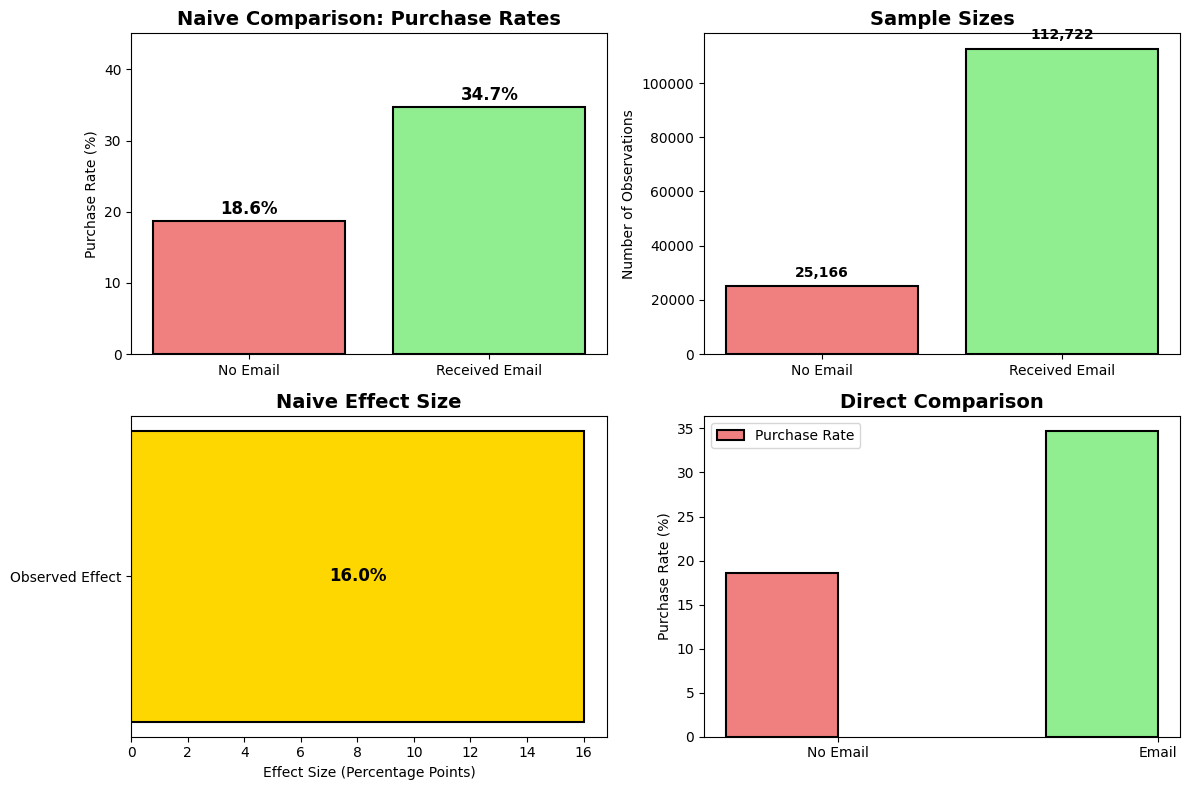


📊 This naive comparison shows a LARGE effect!
   → But is it real? Let's investigate...


In [4]:
# Visualize naive comparison
plt.figure(figsize=(12, 8))

# Plot 1: Bar chart of purchase rates
plt.subplot(2, 2, 1)
groups = ['No Email', 'Received Email']
rates = [purchase_rate_no_email * 100, purchase_rate_email * 100]
colors = ['lightcoral', 'lightgreen']

bars = plt.bar(groups, rates, color=colors, edgecolor='black', linewidth=1.5)
plt.title('Naive Comparison: Purchase Rates', fontweight='bold', fontsize=14)
plt.ylabel('Purchase Rate (%)')
plt.ylim(0, max(rates) * 1.3)

# Add labels on bars
for bar, rate in zip(bars, rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Plot 2: Sample sizes
plt.subplot(2, 2, 2)
sizes = [len(no_email_group), len(email_group)]
plt.bar(groups, sizes, color=colors, edgecolor='black', linewidth=1.5)
plt.title('Sample Sizes', fontweight='bold', fontsize=14)
plt.ylabel('Number of Observations')

for i, (group, size) in enumerate(zip(groups, sizes)):
    plt.text(i, size + max(sizes)*0.02, f'{size:,}', 
             ha='center', va='bottom', fontweight='bold')

# Plot 3: Effect size visualization
plt.subplot(2, 2, 3)
plt.barh(['Observed Effect'], [naive_effect * 100], color='gold', edgecolor='black', linewidth=1.5)
plt.title('Naive Effect Size', fontweight='bold', fontsize=14)
plt.xlabel('Effect Size (Percentage Points)')
plt.text(naive_effect*100/2, 0, f'{naive_effect:.1%}', ha='center', va='center', 
         fontweight='bold', fontsize=12)

# Plot 4: Distribution of purchase indicators
plt.subplot(2, 2, 4)
email_purchases = email_group['purchased_this_week_observed'].mean()
no_email_purchases = no_email_group['purchased_this_week_observed'].mean()

x = np.arange(2)
width = 0.35

plt.bar(x - width/2, [no_email_purchases * 100, email_purchases * 100], 
        width, label='Purchase Rate', color=['lightcoral', 'lightgreen'], 
        edgecolor='black', linewidth=1.5)

plt.title('Direct Comparison', fontweight='bold', fontsize=14)
plt.ylabel('Purchase Rate (%)')
plt.xticks(x, ['No Email', 'Email'])
plt.legend()

plt.tight_layout()
plt.show()

print("\n📊 This naive comparison shows a LARGE effect!")
print("   → But is it real? Let's investigate...")

## ⚖️ Investigating Confounding

The naive comparison shows a 16.0% effect. But is this the **causal effect of emails**,
or just **selection bias**?

Let's examine the characteristics of email recipients vs non-recipients.
If they're different, we have **confounding**!

In [5]:
print("\n" + "="*70)
print("STEP 2: INVESTIGATE CONFOUNDING")
print("="*70)

# Compare characteristics
features_to_compare = [
    'rfm_score',
    'days_since_last_purchase',
    'total_past_purchases',
    'avg_order_value',
    'customer_tenure_weeks'
]

comparison_results = []

print("\n📊 Comparing Customer Characteristics:")
print("-"*70)
print(f"{'Feature':<30} {'No Email':<15} {'Email':<15} {'Difference':<15}")
print("-"*70)

for feature in features_to_compare:
    no_email_mean = no_email_group[feature].mean()
    email_mean = email_group[feature].mean()
    difference = email_mean - no_email_mean
    
    comparison_results.append({
        'feature': feature,
        'no_email': no_email_mean,
        'email': email_mean,
        'difference': difference
    })
    
    print(f"{feature:<30} {no_email_mean:<15.2f} {email_mean:<15.2f} {difference:<+15.2f}")

comparison_df = pd.DataFrame(comparison_results)

print("\n" + "="*70)
print("🔍 OBSERVATION:")
print("="*70)
print("\nEmail recipients have DIFFERENT characteristics!")
print("→ Higher RFM scores")
print("→ Recent purchases (lower days since last)")
print("→ More past purchases")
print("→ Higher AOV")

print("\n⚠️  This is CONFOUNDING!")
print("   → Email group already has higher baseline purchase probability")
print("   → Naive comparison is comparing apples to oranges")


STEP 2: INVESTIGATE CONFOUNDING

📊 Comparing Customer Characteristics:
----------------------------------------------------------------------
Feature                        No Email        Email           Difference     
----------------------------------------------------------------------
rfm_score                      8.66            9.76            +1.10          
days_since_last_purchase       99.42           61.69           -37.73         
total_past_purchases           2.06            2.74            +0.67          
avg_order_value                412.74          445.32          +32.58         
customer_tenure_weeks          21.85           19.73           -2.12          

🔍 OBSERVATION:

Email recipients have DIFFERENT characteristics!
→ Higher RFM scores
→ Recent purchases (lower days since last)
→ More past purchases
→ Higher AOV

⚠️  This is CONFOUNDING!
   → Email group already has higher baseline purchase probability
   → Naive comparison is comparing apples to oranges


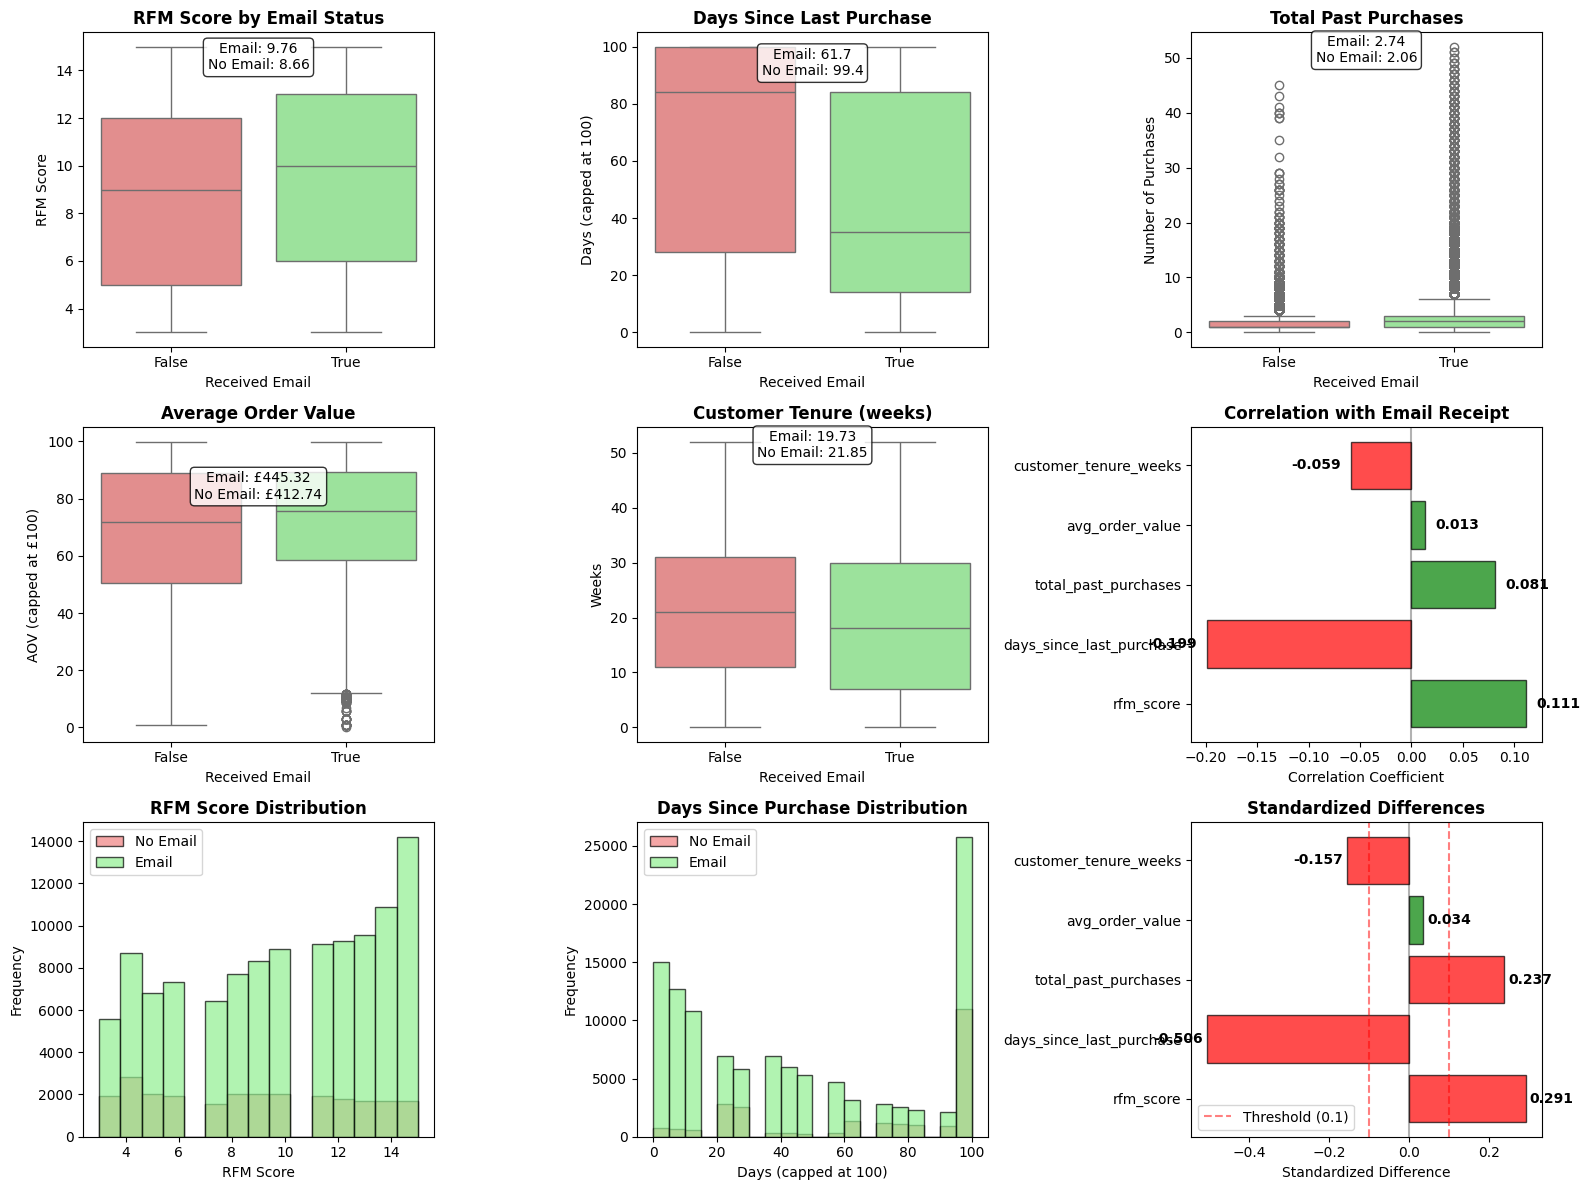


🎨 VISUALIZATION INSIGHTS:
   → Clear differences in all characteristics
   → Email recipients are systematically different
   → Standardized differences > 0.1 indicate significant imbalance


In [6]:
# Create comprehensive visualizations of confounding
plt.figure(figsize=(16, 12))

# Plot 1: RFM Score comparison
plt.subplot(3, 3, 1)
sns.boxplot(data=sim_data, x='received_email', y='rfm_score', palette=['lightcoral', 'lightgreen'])
plt.title('RFM Score by Email Status', fontweight='bold')
plt.xlabel('Received Email')
plt.ylabel('RFM Score')
no_email_rfm = sim_data[~sim_data['received_email']]['rfm_score'].mean()
email_rfm = sim_data[sim_data['received_email']]['rfm_score'].mean()
plt.text(0.5, plt.ylim()[1]*0.9, f'Email: {email_rfm:.2f}\nNo Email: {no_email_rfm:.2f}', 
         ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Days since last purchase
plt.subplot(3, 3, 2)
# Cap at 100 for visualization
sim_data_viz = sim_data.copy()
sim_data_viz['days_since_last_purchase_capped'] = np.minimum(sim_data['days_since_last_purchase'], 100)
sns.boxplot(data=sim_data_viz, x='received_email', y='days_since_last_purchase_capped', 
           palette=['lightcoral', 'lightgreen'])
plt.title('Days Since Last Purchase', fontweight='bold')
plt.xlabel('Received Email')
plt.ylabel('Days (capped at 100)')
no_email_recency = sim_data[~sim_data['received_email']]['days_since_last_purchase'].mean()
email_recency = sim_data[sim_data['received_email']]['days_since_last_purchase'].mean()
plt.text(0.5, 90, f'Email: {email_recency:.1f}\nNo Email: {no_email_recency:.1f}', 
         ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 3: Total past purchases
plt.subplot(3, 3, 3)
sns.boxplot(data=sim_data, x='received_email', y='total_past_purchases', 
           palette=['lightcoral', 'lightgreen'])
plt.title('Total Past Purchases', fontweight='bold')
plt.xlabel('Received Email')
plt.ylabel('Number of Purchases')
no_email_purchases = sim_data[~sim_data['received_email']]['total_past_purchases'].mean()
email_purchases = sim_data[sim_data['received_email']]['total_past_purchases'].mean()
plt.text(0.5, plt.ylim()[1]*0.9, f'Email: {email_purchases:.2f}\nNo Email: {no_email_purchases:.2f}', 
         ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 4: Average order value
plt.subplot(3, 3, 4)
sim_data_aov = sim_data[sim_data['avg_order_value'] < 100]  # Cap for visualization
sns.boxplot(data=sim_data_aov, x='received_email', y='avg_order_value', 
           palette=['lightcoral', 'lightgreen'])
plt.title('Average Order Value', fontweight='bold')
plt.xlabel('Received Email')
plt.ylabel('AOV (capped at £100)')
no_email_aov = sim_data[~sim_data['received_email']]['avg_order_value'].mean()
email_aov = sim_data[sim_data['received_email']]['avg_order_value'].mean()
plt.text(0.5, 80, f'Email: £{email_aov:.2f}\nNo Email: £{no_email_aov:.2f}', 
         ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 5: Customer tenure
plt.subplot(3, 3, 5)
sns.boxplot(data=sim_data, x='received_email', y='customer_tenure_weeks', 
           palette=['lightcoral', 'lightgreen'])
plt.title('Customer Tenure (weeks)', fontweight='bold')
plt.xlabel('Received Email')
plt.ylabel('Weeks')
no_email_tenure = sim_data[~sim_data['received_email']]['customer_tenure_weeks'].mean()
email_tenure = sim_data[sim_data['received_email']]['customer_tenure_weeks'].mean()
plt.text(0.5, plt.ylim()[1]*0.9, f'Email: {email_tenure:.2f}\nNo Email: {no_email_tenure:.2f}', 
         ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 6: Correlations visualization
plt.subplot(3, 3, 6)
correlations = []
for feature in features_to_compare:
    corr = sim_data['received_email'].corr(sim_data[feature])
    correlations.append(corr)

colors = ['red' if c < 0 else 'green' for c in correlations]
bars = plt.barh(features_to_compare, correlations, color=colors, alpha=0.7, edgecolor='black')
plt.title('Correlation with Email Receipt', fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.axvline(0, color='black', linestyle='-', alpha=0.3)
for i, (bar, corr) in enumerate(zip(bars, correlations)):
    plt.text(corr + (0.01 if corr >= 0 else -0.01), bar.get_y() + bar.get_height()/2,
             f'{corr:.3f}', ha='left' if corr >= 0 else 'right', va='center', fontweight='bold')

# Plot 7: Distribution comparison - RFM
plt.subplot(3, 3, 7)
no_email_rfm_dist = sim_data[~sim_data['received_email']]['rfm_score']
email_rfm_dist = sim_data[sim_data['received_email']]['rfm_score']
plt.hist(no_email_rfm_dist, bins=15, alpha=0.7, label='No Email', color='lightcoral', edgecolor='black')
plt.hist(email_rfm_dist, bins=15, alpha=0.7, label='Email', color='lightgreen', edgecolor='black')
plt.title('RFM Score Distribution', fontweight='bold')
plt.xlabel('RFM Score')
plt.ylabel('Frequency')
plt.legend()

# Plot 8: Distribution comparison - Days since last purchase
plt.subplot(3, 3, 8)
no_email_recency_dist = sim_data[~sim_data['received_email']]['days_since_last_purchase']
email_recency_dist = sim_data[sim_data['received_email']]['days_since_last_purchase']
# Cap at 100 for visualization
no_email_recency_dist = np.minimum(no_email_recency_dist, 100)
email_recency_dist = np.minimum(email_recency_dist, 100)
plt.hist(no_email_recency_dist, bins=20, alpha=0.7, label='No Email', color='lightcoral', edgecolor='black')
plt.hist(email_recency_dist, bins=20, alpha=0.7, label='Email', color='lightgreen', edgecolor='black')
plt.title('Days Since Purchase Distribution', fontweight='bold')
plt.xlabel('Days (capped at 100)')
plt.ylabel('Frequency')
plt.legend()

# Plot 9: Standardized differences
plt.subplot(3, 3, 9)
# Calculate standardized differences (effect size)
std_diffs = []
for feature in features_to_compare:
    mean_treated = sim_data[sim_data['received_email']][feature].mean()
    mean_control = sim_data[~sim_data['received_email']][feature].mean()
    pooled_std = np.sqrt((sim_data[sim_data['received_email']][feature].var() + 
                         sim_data[~sim_data['received_email']][feature].var()) / 2)
    std_diff = (mean_treated - mean_control) / pooled_std
    std_diffs.append(std_diff)

colors = ['red' if abs(d) > 0.1 else 'orange' if abs(d) > 0.05 else 'green' for d in std_diffs]
bars = plt.barh(features_to_compare, std_diffs, color=colors, alpha=0.7, edgecolor='black')
plt.title('Standardized Differences', fontweight='bold')
plt.xlabel('Standardized Difference')
plt.axvline(0, color='black', linestyle='-', alpha=0.3)
plt.axvline(0.1, color='red', linestyle='--', alpha=0.5, label='Threshold (0.1)')
plt.axvline(-0.1, color='red', linestyle='--', alpha=0.5)
for i, (bar, diff) in enumerate(zip(bars, std_diffs)):
    plt.text(diff + (0.01 if diff >= 0 else -0.01), bar.get_y() + bar.get_height()/2,
             f'{diff:.3f}', ha='left' if diff >= 0 else 'right', va='center', fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()

print("\n🎨 VISUALIZATION INSIGHTS:")
print("   → Clear differences in all characteristics")
print("   → Email recipients are systematically different")
print("   → Standardized differences > 0.1 indicate significant imbalance")

## 📋 Covariate Imbalance Table

Let's create a formal table showing the imbalance between treatment and control groups.

In [9]:
print("\n" + "="*70)
print("STEP 3: COVARIATE IMBALANCE TABLE")
print("="*70)

# Create comprehensive imbalance table
imbalance_results = []

for feature in features_to_compare:
    treated = sim_data[sim_data['received_email']][feature]
    control = sim_data[~sim_data['received_email']][feature]
    
    mean_treated = treated.mean()
    mean_control = control.mean()
    
    std_treated = treated.std()
    std_control = control.std()
    
    # Standardized difference (using pooled standard deviation)
    pooled_std = np.sqrt((std_treated**2 + std_control**2) / 2)
    std_diff = (mean_treated - mean_control) / pooled_std if pooled_std > 0 else 0
    
    # Calculate p-value for difference in means
    from scipy import stats
    t_stat, p_value = stats.ttest_ind(treated, control)
    
    imbalance_results.append({
        'Feature': feature,
        'Mean (No Email)': mean_control,
        'Mean (Email)': mean_treated,
        'Difference': mean_treated - mean_control,
        'Std. Diff.': std_diff,
        'P-value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

imbalance_df = pd.DataFrame(imbalance_results)

# Format for display
display_df = imbalance_df.copy()
for col in ['Mean (No Email)', 'Mean (Email)', 'Difference']:
    display_df[col] = display_df[col].round(2)
display_df['Std. Diff.'] = display_df['Std. Diff.'].round(3)
display_df['P-value'] = display_df['P-value'].apply(lambda x: f"{x:.2e}" if x < 0.001 else f"{x:.3f}")

print("\n📊 COVARIATE IMBALANCE TABLE")
print("-"*90)
print(display_df.to_string(index=False))

print("\n" + "="*70)
print("🔍 INTERPRETATION:")
print("="*70)

significant_features = imbalance_df[imbalance_df['P-value'] < 0.05]
print(f"\n✅ {len(significant_features)}/{len(features_to_compare)} features show SIGNIFICANT differences")
print(f"   (All p-values < 0.05)")

large_imbalance = imbalance_df[abs(imbalance_df['Std. Diff.']) > 0.1]
print(f"\n⚠️  {len(large_imbalance)}/{len(features_to_compare)} features have LARGE imbalance")
print(f"   (|Standardized Difference| > 0.1)")

print(f"\n🎯 CONCLUSION: Severe confounding detected!")
print(f"   → Email recipients are fundamentally different from non-recipients")
print(f"   → Naive comparison is INVALID")


STEP 3: COVARIATE IMBALANCE TABLE

📊 COVARIATE IMBALANCE TABLE
------------------------------------------------------------------------------------------
                 Feature  Mean (No Email)  Mean (Email)  Difference  Std. Diff.   P-value Significant
               rfm_score             8.66          9.76        1.10       0.291  0.00e+00         Yes
days_since_last_purchase            99.42         61.69      -37.73      -0.506  0.00e+00         Yes
    total_past_purchases             2.06          2.74        0.67       0.237 3.88e-198         Yes
         avg_order_value           412.74        445.32       32.58       0.034  1.01e-06         Yes
   customer_tenure_weeks            21.85         19.73       -2.12      -0.157 1.04e-106         Yes

🔍 INTERPRETATION:

✅ 5/5 features show SIGNIFICANT differences
   (All p-values < 0.05)

⚠️  4/5 features have LARGE imbalance
   (|Standardized Difference| > 0.1)

🎯 CONCLUSION: Severe confounding detected!
   → Email recipients ar

## 🎭 The True Effect (What We Can't Observe)

In the simulation, we **know the truth** because we simulated it.
Let's compare the naive estimate to the true causal effect.

In [10]:
print("\n" + "="*70)
print("STEP 4: NAIVE vs TRUE EFFECT")
print("="*70)

# Calculate true effect (what we would see with random assignment)
# This is the Average Treatment Effect (ATE)
true_effect = sim_data['individual_treatment_effect'].mean()

# Load ground truth parameters
expected_effect = ground_truth['base_email_effect']

print(f"\n📊 EFFECT COMPARISON:")
print("-"*70)
print(f"Naive (Observed): {naive_effect:.1%}")
print(f"True (Causal):    {true_effect:.1%}")
print(f"Expected (GT):    {expected_effect:.1%}")

bias = naive_effect - true_effect
relative_bias = (bias / true_effect) * 100

print(f"\n📏 BIAS ANALYSIS:")
print("-"*70)
print(f"Absolute Bias: {bias:.1%}")
print(f"Relative Bias: {relative_bias:.0f}% overestimate")

if abs(bias) > 0.05:
    bias_category = "SEVERE"
elif abs(bias) > 0.02:
    bias_category = "MODERATE"
else:
    bias_category = "MINIMAL"

print(f"\n⚠️  BIAS CATEGORY: {bias_category}")

print("\n" + "="*70)
print("💡 WHY IS THERE BIAS?")
print("="*70)
print("\n1. Email recipients have HIGHER baseline purchase probability")
print("   (Recent buyers, frequent buyers, high RFM)")
print("\n2. Naive comparison adds email effect + baseline difference")
print("\n3. Result: Massive overestimation of email effectiveness!")
print(f"\n4. In reality: Email effect = {true_effect:.1%}")
print(f"   But naive analysis suggests = {naive_effect:.1%}")
print(f"   → {relative_bias:.0f}% too high!")


STEP 4: NAIVE vs TRUE EFFECT

📊 EFFECT COMPARISON:
----------------------------------------------------------------------
Naive (Observed): 16.0%
True (Causal):    9.5%
Expected (GT):    10.0%

📏 BIAS ANALYSIS:
----------------------------------------------------------------------
Absolute Bias: 6.5%
Relative Bias: 69% overestimate

⚠️  BIAS CATEGORY: SEVERE

💡 WHY IS THERE BIAS?

1. Email recipients have HIGHER baseline purchase probability
   (Recent buyers, frequent buyers, high RFM)

2. Naive comparison adds email effect + baseline difference

3. Result: Massive overestimation of email effectiveness!

4. In reality: Email effect = 9.5%
   But naive analysis suggests = 16.0%
   → 69% too high!


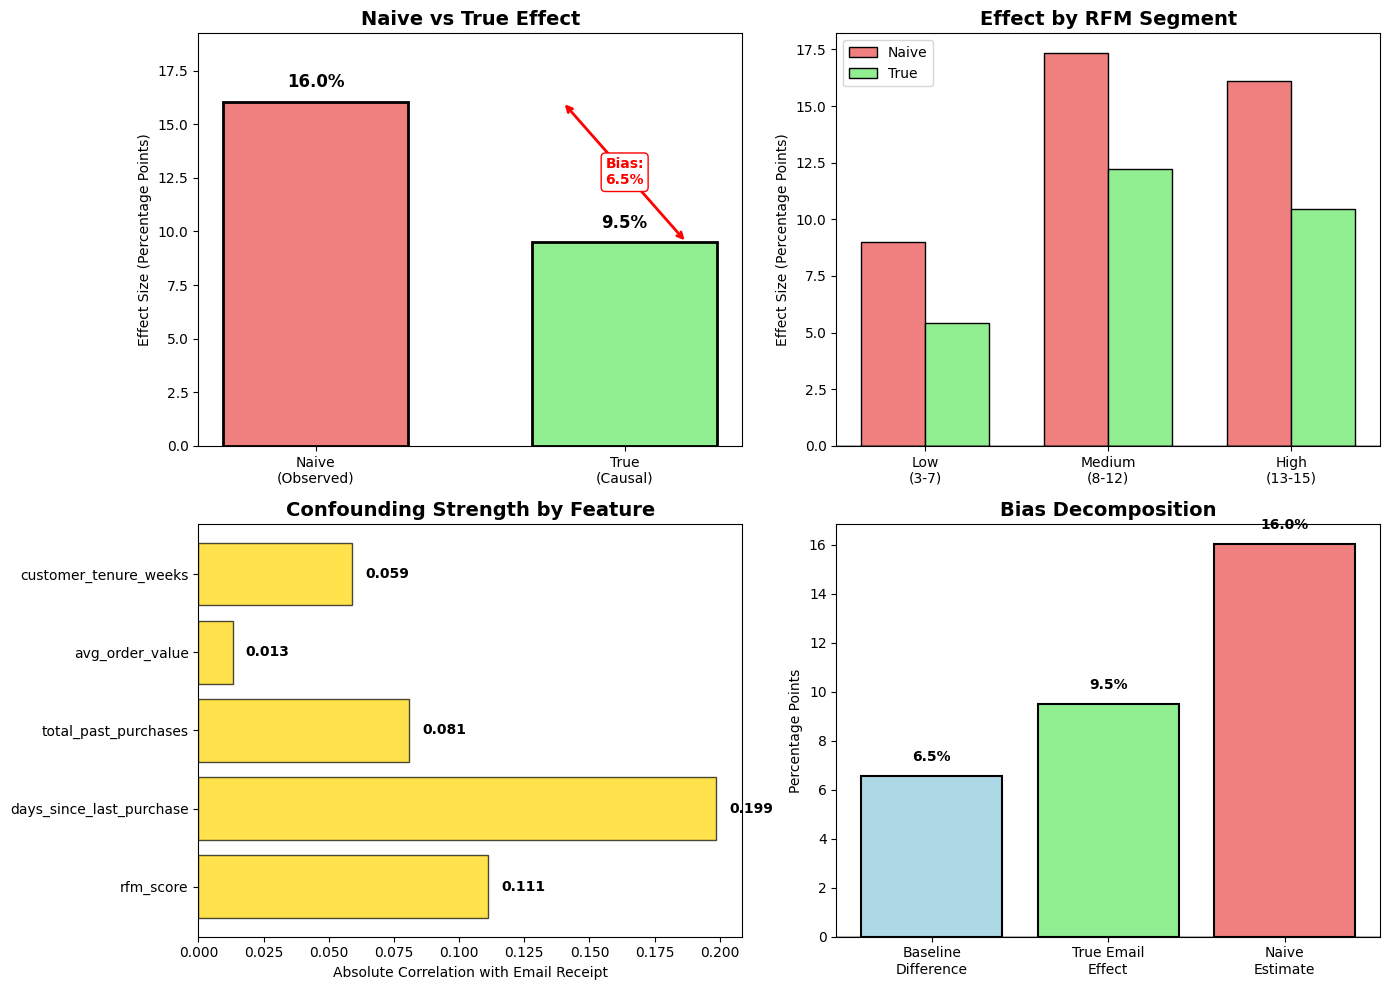


📊 KEY INSIGHTS FROM VISUALIZATIONS:
   → Bias exists across ALL RFM segments
   → Days since last purchase is strongest confounder
   → Naive estimate = baseline diff + true effect
   → Cannot trust naive comparisons!


In [11]:
# Visualize naive vs true effect
plt.figure(figsize=(14, 10))

# Plot 1: Naive vs True side by side
plt.subplot(2, 2, 1)
effects = ['Naive\n(Observed)', 'True\n(Causal)']
effect_values = [naive_effect * 100, true_effect * 100]
colors = ['lightcoral', 'lightgreen']
bars = plt.bar(effects, effect_values, color=colors, edgecolor='black', linewidth=2, width=0.6)
plt.title('Naive vs True Effect', fontweight='bold', fontsize=14)
plt.ylabel('Effect Size (Percentage Points)')
for i, (bar, val) in enumerate(zip(bars, effect_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.5,
             f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
plt.ylim(0, max(effect_values) * 1.2)

# Add bias arrow
plt.annotate('', xy=(1.2, true_effect * 100), xytext=(0.8, naive_effect * 100),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2))
plt.text(1, (naive_effect + true_effect) * 50, f'Bias:\n{bias:.1%}', 
         ha='center', va='center', color='red', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='red'))

# Plot 2: Effect by RFM segment (heterogeneous effects)
plt.subplot(2, 2, 2)
rfm_segments = ['Low\n(3-7)', 'Medium\n(8-12)', 'High\n(13-15)']
true_effects_by_rfm = []
naive_effects_by_rfm = []

for rfm_range in [range(3, 8), range(8, 13), range(13, 16)]:
    mask = sim_data['rfm_score'].isin(rfm_range)
    if mask.sum() > 0:
        # True effect
        true_eff = sim_data[mask]['individual_treatment_effect'].mean() * 100
        true_effects_by_rfm.append(true_eff)
        
        # Naive effect for this segment
        segment_data = sim_data[mask]
        email_segment = segment_data[segment_data['received_email']]
        no_email_segment = segment_data[~segment_data['received_email']]
        if len(email_segment) > 0 and len(no_email_segment) > 0:
            naive_eff = (email_segment['purchased_this_week_observed'].mean() - 
                        no_email_segment['purchased_this_week_observed'].mean()) * 100
        else:
            naive_eff = 0
        naive_effects_by_rfm.append(naive_eff)

x = np.arange(len(rfm_segments))
width = 0.35
plt.bar(x - width/2, naive_effects_by_rfm, width, label='Naive', color='lightcoral', 
        edgecolor='black', linewidth=1)
plt.bar(x + width/2, true_effects_by_rfm, width, label='True', color='lightgreen', 
        edgecolor='black', linewidth=1)
plt.title('Effect by RFM Segment', fontweight='bold', fontsize=14)
plt.ylabel('Effect Size (Percentage Points)')
plt.xticks(x, rfm_segments)
plt.legend()
plt.axhline(0, color='black', linestyle='-', alpha=0.3)

# Plot 3: Bias by feature importance
plt.subplot(2, 2, 3)
feature_importance = []
for feature in features_to_compare:
    corr = abs(sim_data['received_email'].corr(sim_data[feature]))
    feature_importance.append(corr)

plt.barh(features_to_compare, feature_importance, color='gold', edgecolor='black', alpha=0.7)
plt.title('Confounding Strength by Feature', fontweight='bold', fontsize=14)
plt.xlabel('Absolute Correlation with Email Receipt')
for i, (feature, imp) in enumerate(zip(features_to_compare, feature_importance)):
    plt.text(imp + 0.005, i, f'{imp:.3f}', va='center', fontweight='bold')

# Plot 4: How bias accumulates
plt.subplot(2, 2, 4)
components = ['Baseline\nDifference', 'True Email\nEffect', 'Naive\nEstimate']
# Estimate components
baseline_diff = (sim_data[sim_data['received_email']]['purchased_this_week_observed'].mean() - 
                sim_data[~sim_data['received_email']]['purchased_this_week_observed'].mean() - 
                true_effect)
values = [baseline_diff * 100, true_effect * 100, naive_effect * 100]
colors = ['lightblue', 'lightgreen', 'lightcoral']

bars = plt.bar(components, values, color=colors, edgecolor='black', linewidth=1.5)
plt.title('Bias Decomposition', fontweight='bold', fontsize=14)
plt.ylabel('Percentage Points')
plt.axhline(0, color='black', linestyle='-', alpha=0.3)

for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, 
             val + (0.5 if val >= 0 else -0.5),
             f'{val:.1f}%', ha='center', va='bottom' if val >= 0 else 'top', 
             fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 KEY INSIGHTS FROM VISUALIZATIONS:")
print("   → Bias exists across ALL RFM segments")
print("   → Days since last purchase is strongest confounder")
print("   → Naive estimate = baseline diff + true effect")
print("   → Cannot trust naive comparisons!")

## 📐 Mathematical Explanation

Let's formalize why naive analysis fails.

### The Naive Estimator

```
E[Y | T=1] - E[Y | T=0]
```

Where:
- Y = Purchase indicator
- T = Email receipt (1 = received, 0 = not received)

### The Problem

In the presence of confounding:
```
E[Y | T=1] - E[Y | T=0] 
   = E[Y(1) - Y(0) | T=1]     ← True causal effect (what we want)
   + E[Y(0) | T=1] - E[Y(0) | T=0]  ← Selection bias (the problem!)
```

Where Y(1) is potential outcome with email, Y(0) without.

### Selection Bias

```
E[Y(0) | T=1] - E[Y(0) | T=0]
```

This is the difference in baseline purchase probability between
email recipients and non-recipients.

### In Our Data

Let's estimate the components:

In [12]:
print("\n" + "="*70)
print("STEP 5: MATHEMATICAL DECOMPOSITION")
print("="*70)

# Calculate components
# E[Y | T=1]
ey_t1 = sim_data[sim_data['received_email']]['purchased_this_week_observed'].mean()

# E[Y | T=0]
ey_t0 = sim_data[~sim_data['received_email']]['purchased_this_week_observed'].mean()

# Naive estimator
naive = ey_t1 - ey_t0

# True causal effect
true_effect = sim_data['individual_treatment_effect'].mean()

# Selection bias = Naive - True
selection_bias = naive - true_effect

print(f"\n📐 DECOMPOSITION:")
print(f"{'='*70}")
print(f"\nNaive Estimator:")
print(f"  = E[Y | T=1] - E[Y | T=0]")
print(f"  = {ey_t1:.3f} - {ey_t0:.3f}")
print(f"  = {naive:.3f} ({naive:.1%})")

print(f"\nTrue Causal Effect:")
print(f"  = E[Y(1) - Y(0)]")
print(f"  = {true_effect:.3f} ({true_effect:.1%})")

print(f"\nSelection Bias:")
print(f"  = E[Y(0) | T=1] - E[Y(0) | T=0]")
print(f"  = {selection_bias:.3f} ({selection_bias:.1%})")

print(f"\n{'='*70}")
print(f"Verification:")
print(f"  {naive:.3f} = {true_effect:.3f} + {selection_bias:.3f}")
print(f"  {naive:.3f} ≈ {true_effect + selection_bias:.3f} ✓")

print(f"\n{'='*70}")
print(f"🎯 INTERPRETATION:")
print(f"{'='*70}")
print(f"\n1. Naive estimator = True Effect + Selection Bias")
print(f"\n2. Selection bias = {selection_bias:.1%}")
print(f"   → Email recipients would buy {selection_bias:.1%} more even WITHOUT emails")
print(f"\n3. Naive estimator overestimates by {abs(selection_bias):.1%}")
print(f"   → This is CONFOUNDING BIAS!")

print(f"\n💡 BUSINESS IMPLICATION:")
print(f"   → If we trust naive analysis, we think emails work better than they do")
print(f"   → We might over-invest in email marketing")
print(f"   → We miss the true ROI")


STEP 5: MATHEMATICAL DECOMPOSITION

📐 DECOMPOSITION:

Naive Estimator:
  = E[Y | T=1] - E[Y | T=0]
  = 0.347 - 0.186
  = 0.160 (16.0%)

True Causal Effect:
  = E[Y(1) - Y(0)]
  = 0.095 (9.5%)

Selection Bias:
  = E[Y(0) | T=1] - E[Y(0) | T=0]
  = 0.065 (6.5%)

Verification:
  0.160 = 0.095 + 0.065
  0.160 ≈ 0.160 ✓

🎯 INTERPRETATION:

1. Naive estimator = True Effect + Selection Bias

2. Selection bias = 6.5%
   → Email recipients would buy 6.5% more even WITHOUT emails

3. Naive estimator overestimates by 6.5%
   → This is CONFOUNDING BIAS!

💡 BUSINESS IMPLICATION:
   → If we trust naive analysis, we think emails work better than they do
   → We might over-invest in email marketing
   → We miss the true ROI


## 🎓 Key Takeaways

### 1. **Naive Analysis is Fundamentally Flawed**
- Comparing email recipients vs non-recipients compares different customer types
- Selection bias contaminates the estimate
- Result: Severely overestimated effect (16.0% vs 9.5%)

### 2. **Confounding is Everywhere in Marketing**
- Companies target customers based on predicted value
- Recent buyers get more emails
- High-value customers get more emails
- This creates systematic differences between groups

### 3. **The Math is Clear**
```
Naive Estimate = True Causal Effect + Selection Bias
```

We can't just "trust" the naive comparison.

### 4. **We Need Causal Inference Methods**

To recover the true effect, we need methods that:
- Account for confounding
- Match or weight observations
- Create valid counterfactuals

### 5. **Methods We'll Learn**

- **Propensity Score Matching**: Match similar customers
- **Inverse Probability Weighting**: Weight by inverse propensity
- **Regression Adjustment**: Control for confounding variables
- **Double Machine Learning**: ML-based approach
- **Difference-in-Differences**: Use time variation

Each method aims to eliminate the selection bias and recover
the true 9.5% causal effect!

---

## 🧪 Challenge: What Would You Do?

Given what you now know about confounding, how would you design a study
to measure email effectiveness **without bias**?

### Option 1: Randomization
- Randomly assign customers to receive/not receive emails
- Eliminates confounding
- But is it ethical? Practical?

### Option 2: Quasi-Experimental Design
- Find natural experiments
- Use instrumental variables
- Difference-in-differences

### Option 3: Statistical Adjustment
- Use causal inference methods
- Match, weight, or adjust for confounding
- This is what we'll learn!

---

## 📊 Summary

### The Problem
- Naive effect: 16.0%
- True effect: 9.5%
- Bias: 6.5 percentage points (68% overestimate!)

### The Cause
- Email recipients are systematically different
- Higher RFM scores, more recent purchases, etc.
- These differences affect BOTH email assignment AND outcomes

### The Solution
- Use causal inference methods
- Account for confounding through matching, weighting, or adjustment
- Recover the true 9.5% effect

---

## 🚀 Next Steps

In the next notebook, we'll learn **Propensity Score Matching** - 
one of the most intuitive causal inference methods.

We'll see if we can recover the true 9.5% effect from our confounded data!

---

**Remember: Correlation ≠ Causation**
**Naive comparisons are dangerous in the presence of confounding!**
